In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from os import listdir
sns.set(style="ticks", font_scale=1.2)
plt.rc("axes.spines", top=False, right=False)

from utils import *

OUTPUT measures (4): ['output_entropy', 'output_rank_correct', 'output_logprob_correct', 'output_logprobdiff']
PROCESS measures (15): ['auc_entropy', 'layer_biggest_change_entropy', 'auc_rank_correct', 'layer_biggest_change_rank_correct', 'auc_logprob_correct', 'layer_biggest_change_logprob_correct', 'auc_logprobdiff_pos', 'auc_logprobdiff_neg', 'layer_biggest_change_logprobdiff', 'auc_boosting_pos', 'auc_boosting_neg', 'layer_argmax_boosting', 'twostage_magnitude', 'twostage_magnitude_latter34', 'twostage_layer']


# 1. Read and process model outputs

In [2]:
def expect_dual_processing(r):
    if r.task.startswith("capitals"):
        return r["condition"] == "has_competitor"
    elif r.task == "animals":
        return r["condition"] == "Atypical"
    elif r.task == "gender":
        return r["condition"] == "inconsistent"
    elif r.task == "syllogism":
        return (
            (r.is_realistic) and \
            ((r.is_consistent and not r.is_valid) or (not r.is_consistent and r.is_valid))
        )
    else:
        raise ValueError(f"Unknown task: {r.task}")

def read_all_data(lens="logit_lens"):
    dfs = []
    for task in TASKS:
        print(task)
        try:
            df = pd.read_csv(f"../../data/model_output/processed/{task}_metrics_{lens}.csv")
        except FileNotFoundError:
            print(f"No data for {task} / {lens}; skipping")
            continue
        df["task"] = task
        df["model_family"] = df.model.apply(get_model_family)
        df["model_size"] = df.model.apply(get_model_size)
        df["log_model_size"] = np.log(df["model_size"])
        dfs.append(df)
    df = pd.concat(dfs).reset_index()
    df["expect_dual_processing"] = df.apply(expect_dual_processing, axis=1)
    print(df.groupby("task")["expect_dual_processing"].value_counts())
    df["expect_dual_processing_label"] = df.expect_dual_processing.map({
        True: "Competitor",
        False: "NoCompetitor"
    })
    return df

# Read data from all tasks.
df = read_all_data(lens="logit_lens")
print(df.model.unique())
df.head()

capitals-recall
capitals-recognition
animals
gender
syllogism
task                  expect_dual_processing
animals               False                      234
                      True                       108
capitals-recall       True                       756
                      False                      360
capitals-recognition  True                      1428
                      False                      764
gender                False                      720
                      True                       720
syllogism             False                     2448
                      True                       816
Name: expect_dual_processing, dtype: int64
['Falcon3-10B-Base' 'Falcon3-1B-Base' 'Falcon3-3B-Base' 'Llama-2-13b-hf'
 'Llama-2-70b-hf' 'Llama-2-7b-hf' 'Llama-3.1-405B' 'Llama-3.1-70B'
 'Llama-3.1-8B' 'OLMo-2-0325-32B' 'OLMo-2-1124-13B' 'OLMo-2-1124-7B'
 'gemma-2-27b' 'gemma-2-2b' 'gemma-2-9b' 'gpt2-medium' 'gpt2-xl' 'gpt2']


,index,entity,correct,incorrect,model,item_id,condition,output_entropy,midpoint_entropy,output_rank_correct,...,exemplar_de,profession,unique_id,syllogism_name,order_first,is_valid,is_realistic,is_consistent,expect_dual_processing,expect_dual_processing_label
0,0,Australia,Canberra,Sydney,Falcon3-10B-Base,1.0,has_competitor,1.146191,7.762905,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Competitor
1,1,Brazil,Brasilia,Rio de Janeiro,Falcon3-10B-Base,2.0,has_competitor,2.250329,7.588116,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Competitor
2,2,Canada,Ottawa,Toronto,Falcon3-10B-Base,3.0,has_competitor,1.198626,7.722998,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Competitor
3,3,India,New Delhi,Mumbai,Falcon3-10B-Base,4.0,has_competitor,1.900010,7.512623,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Competitor
4,4,Morrocco,Rabat,Marrakesh,Falcon3-10B-Base,5.0,has_competitor,0.907603,7.695533,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Competitor


# 2. Figure 2a

t-test for capitals-recall, twostage_magnitude: t=10.281034220104239, p=9.498700969078036e-24
t-test for capitals-recognition, twostage_magnitude: t=8.053489711271038, p=1.3074695559706776e-15
t-test for animals, twostage_magnitude: t=1.823013462348652, p=0.06917938477310655
t-test for gender, twostage_magnitude: t=0.25319440978325264, p=0.8001541771384768
t-test for syllogism, twostage_magnitude: t=-0.626200039399831, p=0.5312275556426169
t-test for capitals-recall, twostage_layer: t=22.313567602287094, p=1.8241926921646533e-91
t-test for capitals-recognition, twostage_layer: t=15.587335935001972, p=4.985699181534204e-52
t-test for animals, twostage_layer: t=4.186101293966268, p=3.618274648390643e-05
t-test for gender, twostage_layer: t=3.8942940826273422, p=0.00010300160361648061
t-test for syllogism, twostage_layer: t=4.979552816091434, p=6.703998668151344e-07


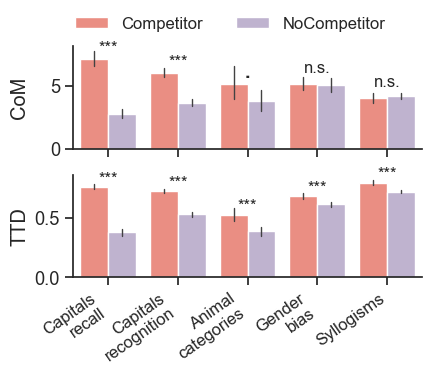

In [3]:
def get_sig_code(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    elif p < 0.1:
        return "."
    else:
        return "n.s."

def plot_com_by_task(d, render=False, annot=True):
    hue_order = ["Competitor", "NoCompetitor"]
    metrics = ["twostage_magnitude", "twostage_layer"]
    ylabels = ["CoM", "TTD"]
    
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(4.5,3))
    
    for i, ax in enumerate(axes):
        metric = metrics[i]
    
        sig_codes = []
        for task in TASKS:
            x1 = d[(d.task==task)&(d.expect_dual_processing)][metric]
            x2 = d[(d.task==task)&(~d.expect_dual_processing)][metric]
            t, p = stats.ttest_ind(x1, x2)
            print(f"t-test for {task}, {metric}: t={t}, p={p}")
            sig_codes.append(get_sig_code(p))

        ax = sns.barplot(
            data=d,
            x="task",
            order=TASKS,
            y=metric,
            hue="expect_dual_processing_label",
            hue_order=hue_order,
            palette=TWOSTAGE_PAL,
            err_kws={"lw": 1},
            ax=ax
        )
        if i == 0:
            ax.legend(
                title="", loc="lower center", bbox_to_anchor=(0.45,1), ncols=2, frameon=False,
                fontsize="small"
            )
        else:
            ax.get_legend().remove()
            ax.set_xticks(
                range(len(TASKS)),
                [TASK_NAMES[t].replace(" ", "\n") for t in TASKS],
                rotation=35,
                ha="right",
                size="small"
            )
        ax.set_xlabel("")
        ax.set_ylabel(ylabels[i])
        
        if annot:
            _, ymax = ax.get_ylim()
            for j, task in enumerate(TASKS):
                y = d[(d.task==task)&(d.expect_dual_processing)][metric].mean()
                sig_code = sig_codes[j]
                if i == 0:
                    y_delta = 0.5 if sig_code != "n.s." else 0.9
                else:
                    y_delta = 0.03
                
                if sig_code == ".":
                    kws = dict(size="medium", weight="bold")
                else:
                    kws = dict(size="small")
                ax.text(j, y+y_delta, sig_code, ha="center", **kws)
        
    fig.align_ylabels()
    plt.subplots_adjust(hspace=0.25)
    if render:
        plt.savefig("../../figures/twostage_means_by_task.pdf", dpi=300, bbox_inches="tight")
    plt.show()
    

plot_com_by_task(df, render=True)

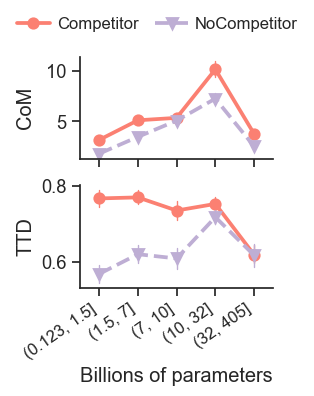

In [4]:
def get_bucket_label(b):
    lo, hi = b.split(", ")
    lo = float(lo.lstrip("("))
    hi = float(hi.rstrip("]"))
    if str(lo).endswith(".0"):
        lo_str = str(int(lo))
    else:
        lo_str = str(lo)
    if str(hi).endswith(".0"):
        hi_str = str(int(hi))
    else:
        hi_str = str(hi)
    return f"({lo_str}, {hi_str}]"
        
def plot_com_by_size(data, n_buckets=4, render=False):
    # Add model size "bucket".
    buckets = pd.qcut(data["model_size"], n_buckets)
    data["model_size_bucket"] = buckets
    order = sorted(data["model_size_bucket"].unique())
    
    metrics = ["twostage_magnitude", "twostage_layer"]
    ylabels = ["CoM", "TTD"]
    
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(2.5,3))
    for i, ax in enumerate(axes):
        metric = metrics[i]
        ax = sns.pointplot(
            data=data,
            x="model_size_bucket",
            order=order,
            y=metric,
            hue="expect_dual_processing_label",
            palette=TWOSTAGE_PAL,
            err_kws=dict(lw=1),
            alpha=1,
            markers=["o", "v"],
            linestyles=["-", "--"],
            ax=ax
        )
        if i == 0:
            ax.legend(
                title="", loc="lower center", bbox_to_anchor=(0.4,1.1), ncol=2,frameon=False,
                columnspacing=1, handletextpad=0.4, fontsize="small"
            )
        else:
            ax.get_legend().remove()
            labs = ax.get_xticklabels()
            pretty_labs = [get_bucket_label(lab.get_text()) for lab in labs]
            ax.set_xticks(
                range(len(labs)),
                pretty_labs,
                rotation=35,
                ha="right",
                size="small"
            )
            ax.set_xlabel("Billions of parameters")
        ax.set_ylabel(ylabels[i])
    fig.align_ylabels()
    plt.subplots_adjust(hspace=0.25)
    if render:
        plt.savefig("../../figures/twostage_by_size.pdf", dpi=300, bbox_inches="tight")
    plt.show()
        
plot_com_by_size(df, n_buckets=5, render=True)

Reading model data for the following task: capitals-recall


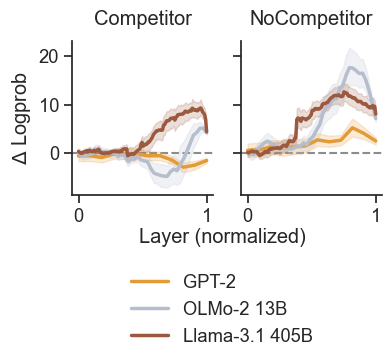

In [5]:
def read_layerwise_data(task, data_dir="../../data/model_output/logit_lens"):
    C_VAR = "correct"
    I_VAR = "incorrect"
    print(f"Reading model data for the following task: {task}")
    dfs = []
    files = sorted([f for f in listdir(data_dir) if f.startswith(task)])
    for file in files:
        model = file.split("_")[-1].strip(".csv")
        if model not in N_LAYERS.keys():
            print(f"Skipping model {model}")
            continue
        df = pd.read_csv(f"{data_dir}/{file}")
        assert df.layer_idx.nunique() == N_LAYERS[model]
        # Add column for whether the layer is the final layer.
        # This is model-dependent.
        max_layer = df["layer_idx"].max()
        df["is_final_layer"] = df["layer_idx"] == max_layer
        # Add normalized layer (between 0-1).
        df["layer_01"] = df["layer_idx"] / max_layer
        df["model"] = model
        dfs.append(df)
    df = pd.concat(dfs).reset_index().drop(columns=["index"])
    # Add columns for logprob diffs.
    for metric in ["sum", "mean", "first"]:
        df[f"{metric}_logprob_diff"] = df[f"{metric}_logprob_{C_VAR}"] - df[f"{metric}_logprob_{I_VAR}"]
    return df

def plot_logprobdiffs(df, models):
    metric_name = "first_logprob_diff"
    palette = ["#E39B38FF", "#B6BDCCFF", "#9B593FFF"]
    conditions = ["has_competitor", "no_competitor"]
    names = ["Competitor", "NoCompetitor"]
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
    for i, ax in enumerate(axes):
        condition = conditions[i]
        ax = sns.lineplot(
            data=df[df.condition==condition],
            x="layer_01",
            y=metric_name, 
            lw=2.5,
            hue="model",
            hue_order=models,
            palette=palette,
            ax=ax
        )
        ax.set_xlabel("")
        if i==0:
            ax.set_ylabel("$\\Delta$ Logprob")
        else:
            ax.set_ylabel("")
        ax.get_legend().remove()
        ax.axhline(y=0, linestyle="--", color="k", alpha=0.5, zorder=-2)
        ax.set_title(names[i], y=1.05)
        
    handles, labels = ax.get_legend_handles_labels()
    labels = [MODEL_MAP[m] for m in labels]
    plt.figlegend(
        handles, labels, title="", loc="upper center", bbox_to_anchor=(0.5, -0.2), 
        ncol=1, frameon=False)
    fig.supxlabel("Layer (normalized)", size="medium", y=-0.15)
    plt.gcf().set_size_inches(4,2)
    
layer_df = read_layerwise_data("capitals-recall")
models = ["gpt2", "OLMo-2-1124-13B", "Llama-3.1-405B"]
plot_logprobdiffs(
    layer_df[(layer_df.model.isin(models))], 
    models
)
plt.savefig(f"../../figures/twostage_layers_capitals-recall.pdf", dpi=300, bbox_inches="tight")

# Appendix

/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_10897/2200234465.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticklabs, size="small")
/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_10897/2200234465.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticklabs, size="small")
/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_10897/2200234465.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticklabs, size="small")
/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_10897/2200234465.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabe

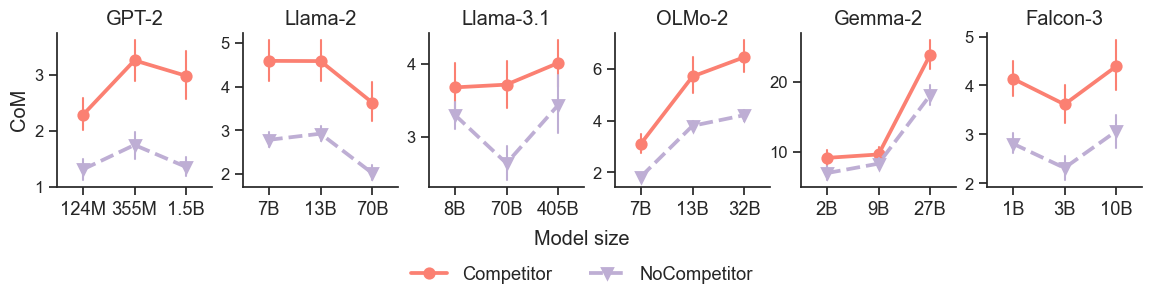

/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_10897/2200234465.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticklabs, size="small")
/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_10897/2200234465.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticklabs, size="small")
/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_10897/2200234465.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticklabs, size="small")
/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_10897/2200234465.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabe

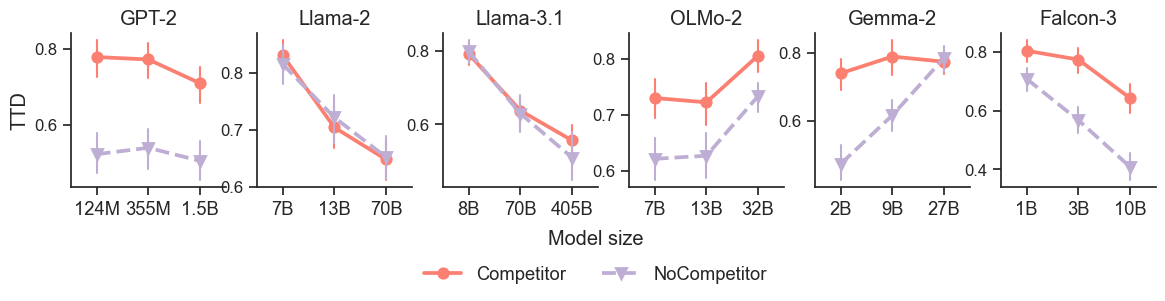

In [6]:
def get_within_family_label(m):
    size = get_model_size(m)
    if size < 1:
        return str(int(size*1000)) + "M"
    else:
        return str(size) + "B"

def plot_dual_processing_metric(d, metric="twostage"):
    order = [
        "Competitor",
        "NoCompetitor"
    ]
    if metric == "twostage_magnitude":
        ylabel = "CoM"
    else:
        ylabel = "TTD"
    fig, axes = plt.subplots(nrows=1, ncols=len(MODEL_FAMILIES), figsize=(14,2))
    for i, (ax, family) in enumerate(zip(axes, MODEL_FAMILIES)):
        models = [m for m in MODELS if get_model_family(m) == family]
        ax = sns.pointplot(
            data=d[d.model_family==family],
            x="model",
            order=models,
            y=metric,
            hue="expect_dual_processing_label",
            hue_order=order,
            palette=TWOSTAGE_PAL,
            ax=ax,
            markers=['o', 'v'],
            linestyles=["-", "--"],
            err_kws=dict(lw=1.5)
        )
        ax.set_title(family)
        ax.set_xlabel("")
        ax.set_xticks(
            range(len(models)), 
            [get_within_family_label(m) for m in models],
        )
        if i == 0:
            ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel("")
        ax.get_legend().remove()
        yticklabs = ax.get_yticklabels()
        ax.set_yticklabels(yticklabs, size="small")

    handles, labels = ax.get_legend_handles_labels()
    fig.supxlabel("Model size", y=-0.2, size="medium")
    plt.figlegend(handles, labels, loc="upper center", bbox_to_anchor=(0.5,-0.2), frameon=False, ncol=2, title="")

for metric in ["twostage_magnitude", "twostage_layer"]:
    plot_dual_processing_metric(
        df,
        metric=metric
    )
    plt.savefig(f"../../figures/{metric}_by_model.pdf", dpi=300, bbox_inches="tight")
    plt.show()